Load images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from glob import glob
import imageio

In [ ]:
!unzip '/content/drive/MyDrive/ADE20K/ADEChallengeData2016.zip'

Streaming output truncated to the last 5000 lines.
 extracting: ADEChallengeData2016/annotations/training/ADE_train_00019018.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00010086.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00002526.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00002954.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00007278.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00012415.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00012867.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00000612.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00016979.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00013255.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_00013980.png  
  inflating: ADEChallengeData2016/annotations/training/ADE_train_0000

In [ ]:
def load_data():
  i_train=sorted(glob(os.path.join('/content/ADEChallengeData2016/images/training','*')))
  a_train=sorted(glob(os.path.join('/content/ADEChallengeData2016/annotations/training','*')))

  i_valid=sorted(glob(os.path.join('/content/ADEChallengeData2016/images/validation','*')))
  a_valid=sorted(glob(os.path.join('/content/ADEChallengeData2016/annotations/validation','*')))
  return (i_train,a_train), (i_valid,a_valid)

def preprocess(img_paths,mask_paths):
  img = tf.io.read_file(img_paths)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img,(128,128))

  mask = tf.io.read_file(mask_paths)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
  mask = tf.image.resize(mask,(128,128))
  return img, mask

def tf_dataset(x,y,batch=16):
  dataset=tf.data.Dataset.from_tensor_slices((x,y))
  dataset=dataset.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
  dataset=dataset.batch(batch)
  # dataset=dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

Erfnet model

In [ ]:
input_shape = (128, 128, 3)
num_classes = 151

In [ ]:
# Non_bottleneck_1D Block
def non_bottleneck_1D(x, filters, strides=(1, 1), dilation = 1):
    residual = x
    # print(residual.shape)

    x = tf.keras.layers.Conv2D(filters, (3, 1), strides=strides, padding = 'same')(x) #activation = 'relu'
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, (1, 3), strides=strides, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, (3, 1), strides=strides, padding = 'same')(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, (1, 3), strides=strides, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # print(x.shape)
    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.ReLU()(x)
    return x

In [ ]:
def ERFNet(num_classes, height, width):
    input_tensor = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    for _ in range(5):
        x = non_bottleneck_1D(x, 64)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    for _ in range(2):
        x = non_bottleneck_1D(x, 128, dilation=2)
        x = non_bottleneck_1D(x, 128, dilation=4)
        x = non_bottleneck_1D(x, 128, dilation=8)
        x = non_bottleneck_1D(x, 128, dilation=16)

    # Decoder
    # print(x.shape, "1")
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides = (2,2), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # print(x.shape, "2")
    for _ in range(2):
        x = non_bottleneck_1D(x, 64)
    # print(x.shape, "3")

    x = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides = (2,2), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # print(x.shape, "4")

    for _ in range(2):
        x = non_bottleneck_1D(x, 16)

    # print(x.shape)
    x = tf.keras.layers.Conv2DTranspose(num_classes, (2,2), strides = (2,2), activation = 'softmax')(x)
    # print(x.shape)
    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

In [ ]:
erfnet_model = ERFNet(151, 128, 128)

In [ ]:
erfnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_71 (Conv2D)          (None, 64, 64, 16)           448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_39 (Ba  (None, 64, 64, 16)           64        ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_70 (ReLU)             (None, 64, 64, 16)           0         ['batch_normalization_39

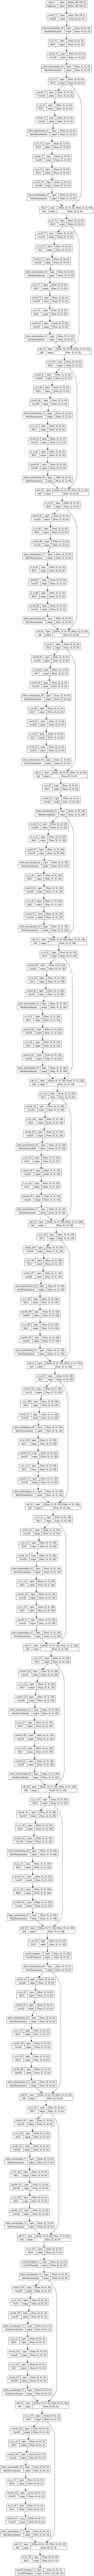

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(erfnet_model, show_shapes = True)

In [ ]:
erfnet_model.compile(optimizer = tf.keras.optimizers.SGD(0.01), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = tf.keras.metrics.BinaryAccuracy())

In [ ]:
(i_train,a_train), (i_valid,a_valid)=load_data()
train_dataset=tf_dataset(i_train,a_train,batch=32)
valid_dataset=tf_dataset(i_valid,a_valid,batch=32)

In [ ]:
callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/ProjectX/ERFNetCheckpoint.h5',verbose=1,save_best_only=True),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=False,patience=20)]
model_history = erfnet_model.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
632/632 [==============================] - ETA: 0s - loss: 4.4529 - binary_accuracy: 0.0808
Epoch 1: val_loss improved from inf to 3.86047, saving model to /content/drive/MyDrive/ProjectX/ERFNetCheckpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


632/632 [==============================] - 151s 199ms/step - loss: 4.4529 - binary_accuracy: 0.0808 - val_loss: 3.8605 - val_binary_accuracy: 0.0737
Epoch 2/20
632/632 [==============================] - ETA: 0s - loss: 3.6549 - binary_accuracy: 0.0808
Epoch 2: val_loss improved from 3.86047 to 3.58435, saving model to /content/drive/MyDrive/ProjectX/ERFNetCheckpoint.h5
632/632 [==============================] - 127s 201ms/step - loss: 3.6549 - binary_accuracy: 0.0808 - val_loss: 3.5843 - val_binary_accuracy: 0.0737
Epoch 3/20
632/632 [==============================] - ETA: 0s - loss: 3.4240 - binary_accuracy: 0.0808
Epoch 3: val_loss improved from 3.58435 to 3.42257, saving model to /content/drive/MyDrive/ProjectX/ERFNetCheckpoint.h5
632/632 [==============================] - 122s 192ms/step - loss: 3.4240 - binary_accuracy: 0.0808 - val_loss: 3.4226 - val_binary_accuracy: 0.0737
Epoch 4/20
632/632 [==============================] - ETA: 0s - loss: 3.2711 - binary_accuracy: 0.0809
Epoc